In [58]:
# Load base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

# load utalities
from tqdm import tqdm
import re
from collections import defaultdict

# load dataset tools
import datasets
from datasets import load_dataset

# preprocessing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# load models
from TorchCRF import CRF
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForTokenClassification,
    AutoConfig,
    AutoTokenizer,
)

# load eval tools
from sklearn.metrics import precision_recall_fscore_support

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set Random States

In [60]:
# set the random states
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

# Load data

Since the handouts are seperate text files we will need to iterate through them and load them into a pandas dataframe.

Each handout will be parsed into lines.

In [61]:
# Extract handout.txt from each subdirectory of RawData
def read_handout_txt():
    data = []

    for root, dirs, files in os.walk("./data/RawData/"):
        try:
            with open(os.path.join(root, "handout.txt"), "r") as f:
                handout = f.readlines()
        except:
            print(f"{root}/handout.txt Not Found")
            continue

        for i, line in enumerate(handout):
            line = line.strip()

            # number lines
            line_dict = {
                "Drug name": root.split("/")[-1],
                "Line number": i + 1,
                "Line": line,
            }

            data.append(line_dict)

    return data

In [62]:
anno_df = pd.read_csv("data/AnnotatedData/AnnotatedDUGData.tsv", sep="\t")

In [63]:
raw_df = pd.DataFrame(read_handout_txt())

./data/RawData//handout.txt Not Found
./data/RawData/Coreg/handout.txt Not Found


In [64]:
raw_df.head()

,Drug name,Line number,Line
0,Abilify,1,Patient Educationaripiprazole intramuscular
1,Abilify,2,IMPORTANT: HOW TO USE THIS INFORMATION: This ...
2,Abilify,3,ARIPIPRAZOLE EXTENDED RELEASE - INJECTION
3,Abilify,4,(AR-i-PIP-ra-zole)
4,Abilify,5,"COMMON BRAND NAME(S): Abilify Maintena, Aristada"


# Filter data

From the annotated data we only need the advice, and drug name and label. We will use the drug identifiers to allign the advice with the correct handout.

In [65]:
anno_df = anno_df[["Drug name", "Drug number", "Advice Text"]]
anno_df.head()

,Drug name,Drug number,Advice Text
0,Abilify,0,To reduce the risk of dizziness and lightheade...
1,Abilify,0,This medication may rarely make your blood sug...
2,Abilify,0,This medication may rarely cause a condition k...
3,Abilify,0,This drug may make you dizzy or drowsy or caus...
4,Abilify,0,Avoid alcoholic beverages.


# Reassign line numbers

The line number present in the data is determined based off of scentence structure and not line number. We will locate the Advice text in the raw text, and assign it a new line number label based on the corresponing line. 

This will help us to assign BIOE tags to the data.

In [66]:
def find_line_number(advice, raw_data_df):

    for i, line in raw_data_df.iterrows():
        if advice in line["Line"]:
            return line["Line number"]
    return None

In [67]:
# Find line number for each advice text
anno_df["Line number"] = anno_df["Advice Text"].apply(
    lambda x: find_line_number(x, raw_df)
)
anno_df.head()

,Drug name,Drug number,Advice Text,Line number
0,Abilify,0,To reduce the risk of dizziness and lightheade...,17.0
1,Abilify,0,This medication may rarely make your blood sug...,20.0
2,Abilify,0,This medication may rarely cause a condition k...,21.0
3,Abilify,0,This drug may make you dizzy or drowsy or caus...,31.0
4,Abilify,0,Avoid alcoholic beverages.,31.0


# Merge data

In [68]:
# merge dataframes
merged_df = pd.merge(anno_df, raw_df, on=["Drug name", "Line number"])
merged_df.head()

,Drug name,Drug number,Advice Text,Line number,Line
0,Abilify,0,To reduce the risk of dizziness and lightheade...,17.0,To reduce the risk of dizziness and lightheade...
1,Abilify,0,This medication may rarely make your blood sug...,20.0,This medication may rarely make your blood sug...
2,Abilify,0,This medication may rarely cause a condition k...,21.0,This medication may rarely cause a condition k...
3,Abilify,0,This drug may make you dizzy or drowsy or caus...,31.0,This drug may make you dizzy or drowsy or caus...
4,Abilify,0,Avoid alcoholic beverages.,31.0,This drug may make you dizzy or drowsy or caus...


In [69]:
merged_df.shape

(909, 5)

# IOB tagging

In [12]:
def generate_bioe_tags(text, advice):
    # basic tokenization
    text_words = text.split()
    advice_words = advice.split()

    start_idx = 0
    end_idx = 0

    advice_len = len(advice_words)

    for i in range(len(text_words)):
        if text_words[i : i + advice_len] == advice_words:
            # print('found')
            start_idx = i
            end_idx = i + advice_len
            break
    # print(start_idx, end_idx)

    # create tags
    tags = ["O"] * len(text_words)
    tags[start_idx] = "B"
    tags[end_idx - 1] = "E"
    for i in range(start_idx + 1, end_idx - 1):
        tags[i] = "I"

    return tags

In [13]:
def encode_tags(tags):
    mapping = {"O": 0, "B": 1, "I": 2, "E": 3}
    return [mapping[tag] for tag in tags]

In [14]:
# tagg the data
tagged_df = merged_df.copy()


tagged_df["labels"] = tagged_df.apply(
    lambda x: generate_bioe_tags(x["Line"], x["Advice Text"]), axis=1
)


# reframe


tagged_df = tagged_df[["Advice Text", "Line", "labels"]]


# rename


tagged_df.columns = ["advice", "text", "labels"]


tagged_df.head()

,advice,text,labels
0,To reduce the risk of dizziness and lightheade...,To reduce the risk of dizziness and lightheade...,"[B, I, I, I, I, I, I, I, I, I, I, I, I, I, I, ..."
1,This medication may rarely make your blood sug...,This medication may rarely make your blood sug...,"[B, I, I, I, I, I, I, I, I, I, I, I, I, I, I, ..."
2,This medication may rarely cause a condition k...,This medication may rarely cause a condition k...,"[B, I, I, I, I, I, I, I, I, I, E, O, O, O, O, ..."
3,This drug may make you dizzy or drowsy or caus...,This drug may make you dizzy or drowsy or caus...,"[B, I, I, I, I, I, I, I, I, I, I, I, I, I, I, ..."
4,Avoid alcoholic beverages.,This drug may make you dizzy or drowsy or caus...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# Convert tagged data to dataset

## Encode the labels

We will convert the BIOE tags to integers, which can be interpreted by the model.

In [15]:
# encode tags
tagged_df["labels"] = tagged_df["labels"].apply(lambda x: encode_tags(x))
tagged_df.head()

,advice,text,labels
0,To reduce the risk of dizziness and lightheade...,To reduce the risk of dizziness and lightheade...,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,This medication may rarely make your blood sug...,This medication may rarely make your blood sug...,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,This medication may rarely cause a condition k...,This medication may rarely cause a condition k...,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, ..."
3,This drug may make you dizzy or drowsy or caus...,This drug may make you dizzy or drowsy or caus...,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,Avoid alcoholic beverages.,This drug may make you dizzy or drowsy or caus...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Evaluate the baseline

For a baseline model we will generate a span that starts at a random position in the line, and ends at a random position between the start and the end of the line. This will give us a random span of text to evaluate the model on.

In [16]:
def pred_random_IOB(text):

    # get the length of the text
    length = len(text)

    # make array of zeros
    preds = np.zeros(length)

    # get a random number between 0 and the length of the text
    random_start = np.random.randint(0, length - 1)
    random_stop = np.random.randint(random_start + 1, length)

    # set the random start to 1
    preds[random_start] = 1

    # set the random stop to 3
    preds[random_stop] = 3

    # set the values in between to 2
    preds[random_start + 1 : random_stop] = 2

    return preds

In [17]:
preds = tagged_df["labels"].apply(pred_random_IOB)

## Evalute the baseline at token level

We will find the accuracy for evaluating the baseline at the token level.

In [18]:
def calculate_accuracy(ground_truth, preds):
    correct = 0
    total = 0
    for true, pred in zip(ground_truth, preds):
        for t, p in zip(true, pred):
            if t == p:
                correct += 1
            total += 1
    return correct / total


# calculate the accuracy of the token level predictions
accuracy = calculate_accuracy(tagged_df["labels"], preds)
accuracy

0.5056711012750547

## Evaluate the baseline at span-level

More important than a token level evaluation is the span level evaluation. We will evaluate the baseline at the span level to see how well it is able to identify the spans. This will be evaluated using precsion, recall, and F1 score.

In [19]:
# evaluate f1 at the span level
def calculate_f1_span_level(ground_truth, preds):
    # flatten the list
    ground_truth = [tag for tags in ground_truth for tag in tags]
    preds = [tag for tags in preds for tag in tags]

    # calculate precision, recall, f1
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        ground_truth, preds, average="macro"
    )

    return precision, recall, f1_score


# calculate f1 at the span level
precision, recall, f1_score = calculate_f1_span_level(
    tagged_df["labels"], preds
)

print("Span-level precision:", precision)

print("Span-level recall:", recall)

print("Span-level F1-score:", f1_score)

Span-level precision: 0.28494639680839756
Span-level recall: 0.2832972496230585
Span-level F1-score: 0.2784944941860884


### Save the results

The baseline results will be saved and compared to the model results

In [20]:
model_results = []

In [21]:
# save the results
model_results.append(
    {
        "Model": "Random Span Baseline",
        "Token-level Accuracy": accuracy,
        "Span-level Precision": precision,
        "Span-level Recall": recall,
        "Span-level F1": f1_score,
    }
)

# Transformer Model

A roBERTa model will be used to predict the BIOE tags for the data. The model will be trained on the previously generated labels in order to predict the BIOE tags for the data, and extract spans of advice. 

In [22]:
model_id = "roberta-base"

## Test Train Split

In [23]:
data = tagged_df.copy()

In [24]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.3, random_state=42)

## Tokenize the data

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

Due to the way the data was labeled, when we tokenize the data we will need to adjust the BIOE tags to match the tokenized data. This involves tokenizing each word individually, and adjusting the BIOE tags to match the tokenized data.

In [26]:
def preprocess_text(example, max_length=512):
    # Because of the way that the BIOE tagging was setup, we need to make sure that the
    # tokenization is aligned with the tagging. This means that we need to tokenize the
    # text and then assign the correct label to each token.

    text = example["text"].split()
    tags = example["labels"]

    token_ids = [tokenizer.cls_token_id]
    label_alignment = [0]
    attention_mask = [1]
    special_label_for_subwords = -100

    for word, label in zip(text, tags):
        subword_tokens = tokenizer.tokenize(word)

        if len(subword_tokens) > 0:
            token_ids.extend(tokenizer.convert_tokens_to_ids(subword_tokens))
            # Assign the correct label to the first subword token
            label_alignment.append(label)
            # Use a special label for subsequent subword tokens
            label_alignment.extend(
                [special_label_for_subwords] * (len(subword_tokens) - 1)
            )
            attention_mask.extend([1] * len(subword_tokens))

    # add [SEP] token
    token_ids.append(tokenizer.sep_token_id)
    label_alignment.append(0)
    attention_mask.append(1)

    # pad to max length
    padding_length = max_length - len(token_ids)
    token_ids.extend([tokenizer.pad_token_id] * padding_length)
    label_alignment.extend([0] * padding_length)
    attention_mask.extend([0] * padding_length)

    # Make sure everything has correct length
    assert len(token_ids) == max_length
    assert len(label_alignment) == max_length
    assert len(attention_mask) == max_length

    return {
        "input_ids": token_ids,
        "labels": label_alignment,
        "attention_mask": attention_mask,
    }

In [27]:
train_dataset = datasets.Dataset.from_pandas(train)
val_dataset = datasets.Dataset.from_pandas(val)
test_dataset = datasets.Dataset.from_pandas(test)

In [28]:
train_dataset = train_dataset.map(preprocess_text)
val_dataset = val_dataset.map(preprocess_text)
test_dataset = test_dataset.map(preprocess_text)

train_dataset.set_format(
    type="torch", columns=["input_ids", "labels", "attention_mask"]
)
val_dataset.set_format(
    type="torch", columns=["input_ids", "labels", "attention_mask"]
)
test_dataset.set_format(
    type="torch", columns=["input_ids", "labels", "attention_mask"]
)

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

The subwords which were added and not part of the original data will be labeled as -100. These will be ignored by the loss function of our model.

In [29]:
# look at first example input_ids and labels
train_dataset[4]["labels"]

tensor([   0,    1,    2,    2,    2,    2,    2,    2, -100,    2,    2, -100,
           2, -100, -100,    2, -100,    2,    2,    2,    3, -100, -100, -100,
        -100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

## Model Setup

In order to increase the accuracy in creating spans of tokens, rather than classifying each token, the base model will be modified. A CRF layer will be added to the model to predict the BIOE tags for the data.

In [30]:
class AutoModelForTokenClassificationCRF(AutoModelForTokenClassification):
    def __init__(self, config):
        super().__init__(config)
        self.crf = CRF(config.num_labels, batch_first=True)

    def forward(
        self, input_ids, attention_mask=None, labels=None, token_type_ids=None
    ):
        outputs = super().forward(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        sequence_output = outputs[0]

        if labels is not None:
            # During training, we use the CRF layer to calculate the loss
            log_likelihood = self.crf(
                sequence_output,
                labels,
                mask=attention_mask.byte(),
                reduction="mean",
            )
            loss = -log_likelihood  # Negative log-likelihood
            return loss
        else:
            # During prediction, we decode the best label sequence
            prediction = self.crf.decode(
                sequence_output, mask=attention_mask.byte()
            )
            return prediction

In [31]:
# get default config
config = AutoConfig.from_pretrained(model_id, num_labels=4)

# load adjusted CRF model and pretrained roBERTa


model = AutoModelForTokenClassificationCRF.from_pretrained(
    model_id, config=config
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training Arguments

In [32]:
# define training arguments

training_args = TrainingArguments(
    output_dir=f"./models/information_extraction/{model_id}",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
)

## Establish Trainer

The loss function for the trainer will be adjusted to emphasize the tags corresponing the beginning and end of the span. This will help to address the imbalance of labels in each line.

In [33]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # custom weights to handle class imbalance
        class_weights = torch.tensor([1.0, 5.0, 1.0, 5.0]).to(logits.device)

        loss_fct = torch.nn.CrossEntropyLoss(
            weight=class_weights, ignore_index=-100
        )
        loss = loss_fct(
            logits.view(-1, self.model.config.num_labels), labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

In [34]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the model

In [35]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mattcalc. Use `wandb login --relogin` to force relogin


  0%|          | 0/381 [00:00<?, ?it/s]

{'loss': 1.2225, 'grad_norm': 13.091547012329102, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.08}
{'loss': 1.0889, 'grad_norm': 12.76552963256836, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.16}
{'loss': 0.8535, 'grad_norm': 13.330708503723145, 'learning_rate': 3e-06, 'epoch': 0.24}
{'loss': 0.4929, 'grad_norm': 8.067225456237793, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.31}
{'loss': 0.2315, 'grad_norm': 1.4240813255310059, 'learning_rate': 5e-06, 'epoch': 0.39}
{'loss': 0.1476, 'grad_norm': 1.081498146057129, 'learning_rate': 6e-06, 'epoch': 0.47}
{'loss': 0.1476, 'grad_norm': 1.562260389328003, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.55}
{'loss': 0.1363, 'grad_norm': 0.9602494239807129, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.63}
{'loss': 0.1252, 'grad_norm': 6.804224014282227, 'learning_rate': 9e-06, 'epoch': 0.71}
{'loss': 0.1131, 'grad_norm': 1.966797113418579, 'learning_rate': 1e-05, 'epoch': 0.79}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.11931750923395157, 'eval_runtime': 4.451, 'eval_samples_per_second': 49.202, 'eval_steps_per_second': 12.357, 'epoch': 0.79}
{'loss': 0.1214, 'grad_norm': 1.766493320465088, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.87}
{'loss': 0.1184, 'grad_norm': 1.0284651517868042, 'learning_rate': 1.2e-05, 'epoch': 0.94}
{'loss': 0.101, 'grad_norm': 0.6729875802993774, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.02}
{'loss': 0.086, 'grad_norm': 1.6426829099655151, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.1}
{'loss': 0.074, 'grad_norm': 1.2343101501464844, 'learning_rate': 1.5e-05, 'epoch': 1.18}
{'loss': 0.0876, 'grad_norm': 1.0885262489318848, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.26}
{'loss': 0.0851, 'grad_norm': 1.3373186588287354, 'learning_rate': 1.7000000000000003e-05, 'epoch': 1.34}
{'loss': 0.1001, 'grad_norm': 0.6080832481384277, 'learning_rate': 1.8e-05, 'epoch': 1.42}
{'loss': 0.0689, 'grad_norm': 1.494107723236084, 'learning_ra

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.07510264217853546, 'eval_runtime': 4.5006, 'eval_samples_per_second': 48.661, 'eval_steps_per_second': 12.221, 'epoch': 1.57}
{'loss': 0.0708, 'grad_norm': 2.3471944332122803, 'learning_rate': 2.1e-05, 'epoch': 1.65}
{'loss': 0.0677, 'grad_norm': 1.0438623428344727, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.73}
{'loss': 0.0734, 'grad_norm': 2.159069776535034, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.81}
{'loss': 0.076, 'grad_norm': 2.1525163650512695, 'learning_rate': 2.4e-05, 'epoch': 1.89}
{'loss': 0.0689, 'grad_norm': 0.3972097337245941, 'learning_rate': 2.5e-05, 'epoch': 1.97}
{'loss': 0.0667, 'grad_norm': 1.0183829069137573, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.05}
{'loss': 0.0728, 'grad_norm': 0.5551657676696777, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.13}
{'loss': 0.0641, 'grad_norm': 0.8768353462219238, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.2}
{'loss': 0.0755, 'grad_norm': 1.3451433181762695, 'learnin

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.08512064814567566, 'eval_runtime': 4.4684, 'eval_samples_per_second': 49.01, 'eval_steps_per_second': 12.309, 'epoch': 2.36}
{'loss': 0.0685, 'grad_norm': 1.3564298152923584, 'learning_rate': 3.1e-05, 'epoch': 2.44}
{'loss': 0.0665, 'grad_norm': 0.7612689733505249, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.52}
{'loss': 0.0703, 'grad_norm': 0.697179913520813, 'learning_rate': 3.3e-05, 'epoch': 2.6}
{'loss': 0.0755, 'grad_norm': 1.4726669788360596, 'learning_rate': 3.4000000000000007e-05, 'epoch': 2.68}
{'loss': 0.0708, 'grad_norm': 0.5462049245834351, 'learning_rate': 3.5e-05, 'epoch': 2.76}
{'loss': 0.0751, 'grad_norm': 0.9193570613861084, 'learning_rate': 3.6e-05, 'epoch': 2.83}
{'loss': 0.0698, 'grad_norm': 1.4892141819000244, 'learning_rate': 3.7e-05, 'epoch': 2.91}
{'loss': 0.0755, 'grad_norm': 0.6470749974250793, 'learning_rate': 3.8e-05, 'epoch': 2.99}
{'train_runtime': 128.6819, 'train_samples_per_second': 11.843, 'train_steps_per_second': 2.961, 'train

TrainOutput(global_step=381, training_loss=0.17770351774579896, metrics={'train_runtime': 128.6819, 'train_samples_per_second': 11.843, 'train_steps_per_second': 2.961, 'train_loss': 0.17770351774579896, 'epoch': 3.0})

# Predictions and Post-Processing

Predictions will be made on the withheld test data and the model will be evaluated. Additionally, a postprocessing will also be applied and the results compared.

In [36]:
# make prediction with the trainer on the test text
preds = trainer.predict(test_dataset)

# get the predicted labels
pred_labels = np.argmax(preds.predictions, axis=2)
pred_labels[0]

  0%|          | 0/46 [00:00<?, ?it/s]

array([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0,
       0, 0, 3, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Base Predictions

### Accuracy

In [37]:
# calculate accuracy based on non-padding tokens
def calculate_accuracy_non_padding(predictions, labels, attention_mask):
    correct = 0
    total = 0
    for pred, label, mask in zip(predictions, labels, attention_mask):
        # print(pred, label, mask)
        for p, l, m in zip(pred, label, mask):
            if m == 1:
                if p == l:
                    correct += 1
                total += 1
    return correct / total

In [38]:
attention_mask = test_dataset["attention_mask"]

# convert pred_labels to tensor
pred_labels = torch.tensor(pred_labels).to(device)

calculate_accuracy_non_padding(
    pred_labels, test_dataset["labels"], test_dataset["attention_mask"]
)

0.4347894903450459

### Precision, Recall, F1

In [39]:
# calculate span-level f1
precision, recall, f1_score = calculate_f1_span_level(
    test_dataset["labels"].to("cpu"), pred_labels.to("cpu")
)

print("Span-level precision:", precision)
print("Span-level recall:", recall)
print("Span-level F1-score:", f1_score)

Span-level precision: 0.4242374685868067
Span-level recall: 0.6567602589964118
Span-level F1-score: 0.49179318623185236


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
model_results.append(
    {
        "Model": "RoBERTa-CRF",
        "Token-level Accuracy": accuracy,
        "Span-level Precision": precision,
        "Span-level Recall": recall,
        "Span-level F1": f1_score,
    }
)

## Post-Processed Predictions

In [41]:
def postprocess_preds(pred_labels):
    # takes an array of preds and postprocesses them
    filled_array = np.copy(pred_labels)
    num_examples, width = filled_array.shape

    for i in range(num_examples):
        first_1_index = np.where(filled_array[i] == 1)[0]
        first_3_index = np.where(filled_array[i] == 3)[0]

        if len(first_1_index) > 0 and len(first_3_index) > 0:
            start_index = first_1_index[0]
            end_index = first_3_index[0]

            filled_array[i, start_index + 1 : end_index] = 2

    return filled_array

In [42]:
pred_labels = postprocess_preds(pred_labels.to("cpu"))
pred_labels[1]

array([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 1, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Accuracy

In [43]:
attention_mask = test_dataset["attention_mask"]

# convert pred_labels to tensor
pred_labels = torch.tensor(pred_labels).to(device)

accuracy = calculate_accuracy_non_padding(
    pred_labels, test_dataset["labels"], test_dataset["attention_mask"]
)

### Precision, Recall, F1

In [44]:
# calculate span-level f1
precision, recall, f1_score = calculate_f1_span_level(
    test_dataset["labels"].to("cpu"), pred_labels.to("cpu")
)

print("Span-level precision:", precision)
print("Span-level recall:", recall)
print("Span-level F1-score:", f1_score)

Span-level precision: 0.4117042877153592
Span-level recall: 0.6792628833141559
Span-level F1-score: 0.48745172449814883


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# save the results
model_results.append(
    {
        "Model": "RoBERTa-CRF - Postprocessed",
        "Token-level Accuracy": accuracy,
        "Span-level Precision": precision,
        "Span-level Recall": recall,
        "Span-level F1": f1_score,
    }
)

# Test the non-CRF model

In [46]:
model = AutoModelForTokenClassification.from_pretrained(model_id, num_labels=4)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Train the model

In [47]:
trainer.train()

  0%|          | 0/381 [00:00<?, ?it/s]

{'loss': 1.4109, 'grad_norm': 12.196011543273926, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.08}
{'loss': 1.3042, 'grad_norm': 12.591379165649414, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.16}
{'loss': 1.0961, 'grad_norm': 12.313448905944824, 'learning_rate': 3e-06, 'epoch': 0.24}
{'loss': 0.6525, 'grad_norm': 12.853316307067871, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.31}
{'loss': 0.2426, 'grad_norm': 2.527519702911377, 'learning_rate': 5e-06, 'epoch': 0.39}
{'loss': 0.1436, 'grad_norm': 0.8862079977989197, 'learning_rate': 6e-06, 'epoch': 0.47}
{'loss': 0.1413, 'grad_norm': 2.2489795684814453, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.55}
{'loss': 0.13, 'grad_norm': 0.8151608109474182, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.63}
{'loss': 0.1176, 'grad_norm': 0.812470018863678, 'learning_rate': 9e-06, 'epoch': 0.71}
{'loss': 0.1143, 'grad_norm': 1.8471317291259766, 'learning_rate': 1e-05, 'epoch': 0.79}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.11988736689090729, 'eval_runtime': 4.4768, 'eval_samples_per_second': 48.919, 'eval_steps_per_second': 12.285, 'epoch': 0.79}
{'loss': 0.1232, 'grad_norm': 0.6255847811698914, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.87}
{'loss': 0.1168, 'grad_norm': 2.4987900257110596, 'learning_rate': 1.2e-05, 'epoch': 0.94}
{'loss': 0.0995, 'grad_norm': 0.4271621108055115, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.02}
{'loss': 0.0881, 'grad_norm': 1.0332731008529663, 'learning_rate': 1.4000000000000001e-05, 'epoch': 1.1}
{'loss': 0.0749, 'grad_norm': 1.214789628982544, 'learning_rate': 1.5e-05, 'epoch': 1.18}
{'loss': 0.0878, 'grad_norm': 0.8909400701522827, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.26}
{'loss': 0.0822, 'grad_norm': 1.1346067190170288, 'learning_rate': 1.7000000000000003e-05, 'epoch': 1.34}
{'loss': 0.1057, 'grad_norm': 0.5494030714035034, 'learning_rate': 1.8e-05, 'epoch': 1.42}
{'loss': 0.0692, 'grad_norm': 1.2239781618118286, 'learni

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.07705149054527283, 'eval_runtime': 4.5043, 'eval_samples_per_second': 48.62, 'eval_steps_per_second': 12.21, 'epoch': 1.57}
{'loss': 0.0707, 'grad_norm': 2.4502975940704346, 'learning_rate': 2.1e-05, 'epoch': 1.65}
{'loss': 0.07, 'grad_norm': 3.9618430137634277, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.73}
{'loss': 0.0724, 'grad_norm': 2.534353017807007, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.81}
{'loss': 0.0736, 'grad_norm': 0.599075973033905, 'learning_rate': 2.4e-05, 'epoch': 1.89}
{'loss': 0.0696, 'grad_norm': 1.4834799766540527, 'learning_rate': 2.5e-05, 'epoch': 1.97}
{'loss': 0.0704, 'grad_norm': 1.0418800115585327, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.05}
{'loss': 0.0721, 'grad_norm': 0.5119318962097168, 'learning_rate': 2.7000000000000002e-05, 'epoch': 2.13}
{'loss': 0.0654, 'grad_norm': 0.5264772772789001, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.2}
{'loss': 0.0717, 'grad_norm': 1.2495018243789673, 'learning_ra

  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.0847989097237587, 'eval_runtime': 4.4906, 'eval_samples_per_second': 48.768, 'eval_steps_per_second': 12.248, 'epoch': 2.36}
{'loss': 0.0675, 'grad_norm': 0.9074564576148987, 'learning_rate': 3.1e-05, 'epoch': 2.44}
{'loss': 0.0724, 'grad_norm': 0.5865559577941895, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.52}
{'loss': 0.0695, 'grad_norm': 0.21899786591529846, 'learning_rate': 3.3e-05, 'epoch': 2.6}
{'loss': 0.0676, 'grad_norm': 1.5039243698120117, 'learning_rate': 3.4000000000000007e-05, 'epoch': 2.68}
{'loss': 0.0755, 'grad_norm': 0.7401970028877258, 'learning_rate': 3.5e-05, 'epoch': 2.76}
{'loss': 0.0732, 'grad_norm': 0.48361268639564514, 'learning_rate': 3.6e-05, 'epoch': 2.83}
{'loss': 0.0675, 'grad_norm': 1.386540174484253, 'learning_rate': 3.7e-05, 'epoch': 2.91}
{'loss': 0.0706, 'grad_norm': 1.100571632385254, 'learning_rate': 3.8e-05, 'epoch': 2.99}
{'train_runtime': 126.2332, 'train_samples_per_second': 12.073, 'train_steps_per_second': 3.018, 'trai

TrainOutput(global_step=381, training_loss=0.19836613750989668, metrics={'train_runtime': 126.2332, 'train_samples_per_second': 12.073, 'train_steps_per_second': 3.018, 'train_loss': 0.19836613750989668, 'epoch': 3.0})

## Predictions and Post-Processing

In [48]:
# make prediction with the trainer on the test text
preds = trainer.predict(test_dataset)

# get the predicted labels
pred_labels = np.argmax(preds.predictions, axis=2)
pred_labels[0]

  0%|          | 0/46 [00:00<?, ?it/s]

array([0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Base Predictions

### Accuracy

In [49]:
attention_mask = test_dataset["attention_mask"]

# convert pred_labels to tensor
pred_labels = torch.tensor(pred_labels).to(device)

calculate_accuracy_non_padding(
    pred_labels, test_dataset["labels"], test_dataset["attention_mask"]
)

0.43597657486546376

### Precision, Recall, F1

In [50]:
# calculate span-level f1
precision, recall, f1_score = calculate_f1_span_level(
    test_dataset["labels"].to("cpu"), pred_labels.to("cpu")
)

print("Span-level precision:", precision)
print("Span-level recall:", recall)
print("Span-level F1-score:", f1_score)

Span-level precision: 0.41997098468744765
Span-level recall: 0.6353782940936759
Span-level F1-score: 0.47615836046141985


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
model_results.append(
    {
        "Model": "RoBERTa",
        "Token-level Accuracy": accuracy,
        "Span-level Precision": precision,
        "Span-level Recall": recall,
        "Span-level F1": f1_score,
    }
)

## Post-Processed Predictions

In [52]:
pred_labels = postprocess_preds(pred_labels.to("cpu"))
pred_labels[1]

array([0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Accuracy

In [53]:
attention_mask = test_dataset["attention_mask"]

# convert pred_labels to tensor
pred_labels = torch.tensor(pred_labels).to(device)

accuracy = calculate_accuracy_non_padding(
    pred_labels, test_dataset["labels"], test_dataset["attention_mask"]
)

### Precision, Recall, F1

In [54]:
# calculate span-level f1
precision, recall, f1_score = calculate_f1_span_level(
    test_dataset["labels"].to("cpu"), pred_labels.to("cpu")
)


print("Span-level precision:", precision)
print("Span-level recall:", recall)
print("Span-level F1-score:", f1_score)

Span-level precision: 0.41343688806378587
Span-level recall: 0.6909097921682128
Span-level F1-score: 0.4887624903848783


c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# save the results
model_results.append(
    {
        "Model": "RoBERTa - Postprocessed",
        "Token-level Accuracy": accuracy,
        "Span-level Precision": precision,
        "Span-level Recall": recall,
        "Span-level F1": f1_score,
    }
)

# Results Comparison

In [56]:
# save the results
model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv("ie_model_results.csv", index=False)

c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Matt\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

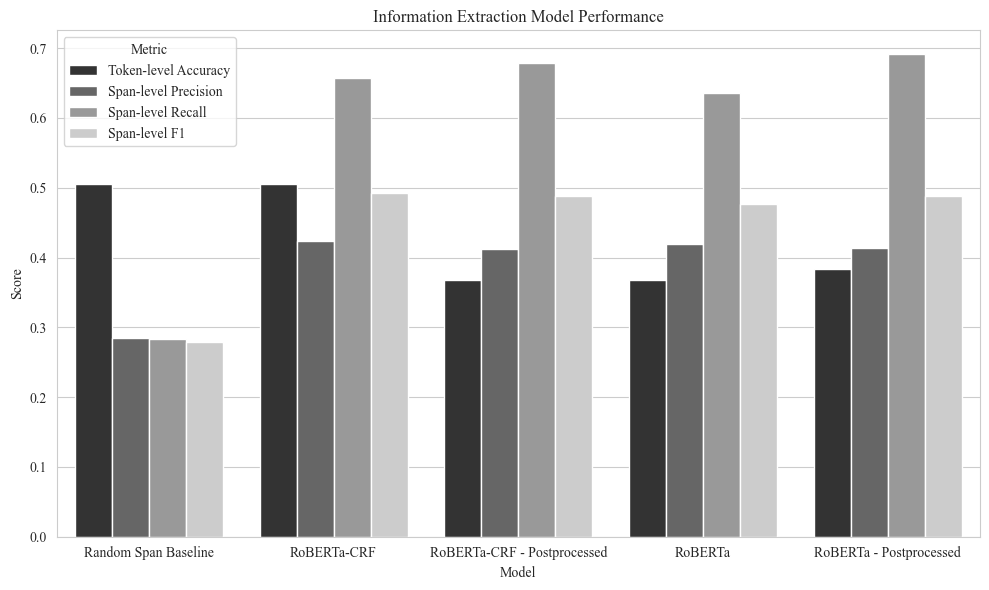

In [57]:
# melt the data
model_results_melted = model_results_df.melt(
    id_vars="Model", var_name="Metric", value_name="Score"
)

# set style
sns.set_style("whitegrid")

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# plot the results
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Model",
    y="Score",
    hue="Metric",
    data=model_results_melted,
    palette="gray",
)
plt.title("Information Extraction Model Performance")
plt.ylabel("Score")
plt.tight_layout()
# save plot
plt.savefig("./images/ie_model_performance.png")
plt.show()

The transformer based model preformed signifigantly better than the random baseline, however the evaluation scores were still relatively low. With more data to train the model, there is potential for the model to improve.

The post-processing caused a decrease in token level accuracy, however offered a slight increade in span level evaluation. Since the main emphasis is on the span level evaluation, the post-processed model is the better choice.

# ---------------------